<a href="https://colab.research.google.com/github/cloudwalk/activerecord-clean-db-structure/blob/master/automatic_open_infraction_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#@title -- Getting necessary API KEY

from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import json
from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [20]:
#@title -- Google auth colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
#@title -- Auth BigQuery Credentials

auth.authenticate_user()
bqclient = bigquery.Client('infinitepay-production')

In [22]:
#@title -- Getting relevant API Keys


def get_api_keys():
  file_path = "/content/drive/MyDrive/infractions_key/relevant_api_keys.json"

  with open(file_path, "r") as file1:
    keys_json = json.load(file1)

  key_master = keys_json.get('key_master')
  pix_infraction_key = keys_json.get('key_master')

  return key_master, pix_infraction_key

key_master, pix_infraction_key = get_api_keys()

In [23]:
key_master

'e29b01bb68ac56681532728825983123'

In [24]:
#@title -- Query

# fake amount e stolen card
query = '''
   WITH get_blocked_users AS (
          SELECT
          an.user_id,
          an.id,
          o.offense_group,
          o.name,
          an.description,
          an.created_at,
          u.status
          FROM maindb.offense_analyses an
          JOIN maindb.users u ON u.id = an.user_id
          JOIN maindb.offenses o ON o.id = an.offense_id
          WHERE ((o.offense_group = 'pix')
          OR (o.offense_group = 'accomplice_fraud' AND o.name = 'consumer_dispute')
          OR (o.offense_group = 'scam' AND o.name IN ('stolen_card', 'fake_amount', 'fake_bank_slip')))
          AND DATE(an.created_at) >= current_date() - 3
          AND u.status = 'blocked'
          AND analysis_type IN ('automatic', 'manual')
          AND conclusion = 'offense'
          AND priority = 'high'
          AND automatic_pipeline = TRUE
          AND an.id NOT IN (
          SELECT reversed_analysis_id
          FROM maindb.offense_analyses
          WHERE reversed_analysis_id IS NOT NULL
          )
          ),
          filtered_pix_transfers as (
          SELECT
            pt.id as pix_transfer_id,
            pt.amount/100 AS amount,
            CASE WHEN pt.type_of = 'DEBIT' THEN pt.debitor_user_id WHEN pt.type_of = 'CREDIT' THEN pt.creditor_user_id END as user_id,
            JSON_EXTRACT_SCALAR(pt.credit_party_details, '$.bank') AS bank,
            CASE WHEN pt.type_of = 'DEBIT' THEN 'DEBITED_PARTICIPANT' WHEN pt.type_of = 'CREDIT' THEN 'CREDITED_PARTICIPANT' END AS reported_by,
            pt.created_at AS transaction_date,
            pt.end2end_id AS transaction_id,
            'REFUND_REQUEST' AS infraction_type,
            'Triangulação. Valor originado de fraude confirmada.' AS report_details,
            gbu.offense_group,
            gbu.name
          FROM maindb.pix_transfers pt
          JOIN get_blocked_users gbu ON pt.debitor_user_id = gbu.user_id OR pt.creditor_user_id = gbu.user_id
          WHERE pt.status = 'confirmed'
          AND DATE(pt.created_at) BETWEEN DATE(gbu.created_at) - INTERVAL '3' DAY AND DATE(gbu.created_at)
          AND pt.id NOT IN (
            SELECT pix_transfer_id
            FROM `metrics_risk.pix_infractions`
            )
          )

          SELECT DISTINCT
          fpt.pix_transfer_id,
          fpt.offense_group,
          fpt.user_id,
          fpt.amount,
          fpt.name,
          fpt.reported_by,
          'REFUND_REQUEST' as infraction_type,
          CONCAT(
          '{ "pix_transfer_id": "', fpt.pix_transfer_id,
          '", "user_id": "', fpt.user_id,
          '", "amount": "', fpt.amount,
          '", "offense_group": "', fpt.offense_group,
          '", "name": "', fpt.name,
          '", "fraudster_account": "', fpt.reported_by,
          '", "infraction_type": "', fpt.infraction_type, '" }'
      ) AS payload
          FROM filtered_pix_transfers fpt
          WHERE fpt.bank NOT IN (
          '18189547',
          '30306294',
          '08744817',
          '35523352',
          '13935893'
          )
          AND amount >= 50
'''

df_get_blocked_users = bqclient.query(query).to_dataframe(progress_bar_type='tqdm')

Job ID 9b088bfd-f13b-438a-be5e-b84cf57a70be successfully executed: 100%|██████████|
Downloading: 100%|██████████|


In [25]:
#@title -- Get List of pix_transfer_id

df_get_blocked_users

cashouts_df = pd.DataFrame(df_get_blocked_users, columns=['pix_transfer_id'])
list_of_pix_transfer_id = ','.join(cashouts_df['pix_transfer_id'].astype(str))

In [26]:
list_of_pix_transfer_id

'610933727,609732832,614407004,614570007,615967795,614132717,612951034,615156259,615542406,612884493,616509755,613420654,615557373,611243929,614872803,616387362,608599511,609140850,613339785,616394225,615287764,615983974,613271257,613767894,612875802,613961968,614943435,612860123,613562197,610615862,615607979,613777036,609492026,613554712,612318850,612958304,614345391,611787383,613395758,615554179,616315772,612878655,613185809,613804462,613278215,610939252,613694332,610062167,614158645,612179649,613977706,610848437,612307439,616078380,614959725,611718232,610805037,608508271,609259571,613187562,614889408,614944291,614362224,612961717,609075463,613195132,610053084,614250546,612247019,611960063,612205979,611581951,615055155,611152402,609140453,615019486,613017942,614685574,611756867,614986175,615184545,613456828,609563608,613181478,613467610,609228072,613632880,614160518,614060879,615452425,615697804,612853037,608280795,615240536,612796641,613396404,610902622,609562535,614114764,607721832

In [27]:
cashouts_df = pd.DataFrame(df_get_blocked_users, columns=['user_id'])
list_of_user_ids = ','.join(cashouts_df['user_id'].astype(str))

In [28]:
list_of_user_ids

'27555376,31329281,32389455,18134797,6580952,18134797,27555376,31906542,14608645,27555376,32362890,32300012,22619525,27957009,31329281,25025520,19562847,30546541,32245573,25025520,26249783,32410149,27555376,4023793,27555376,27853492,31608404,27555376,17478184,27555376,4023793,21648281,25967632,27957009,22619525,18705091,32245573,14608645,32362890,31329281,16615636,27555376,32300012,4023793,27555376,27555376,29792417,19562847,26249783,32362890,27853492,27555376,18134797,30555664,32245573,32245573,27555376,29792417,18134797,27555376,31608404,32118984,21648281,27555376,32245573,27555376,9245560,32389455,22619525,18705091,32245573,29932304,26249783,18134797,18134797,2011602,32245573,32245573,4309463,26249783,30352233,4023793,31608404,27555376,27957009,29792417,31953679,26249783,31953679,32362890,4023793,27555376,19907984,28055250,32300012,32300012,27957009,31608404,4023793,2617223,32446457,23289850,24065733,31959076,27957009,31973951,21469116,12157720,18705091,4023793,31973951,22619525,275

In [29]:
#@title -- Get List of pix_transfer_id in DataFrame

df_get_blocked_users

,pix_transfer_id,offense_group,user_id,amount,name,reported_by,infraction_type,payload
0,610933727,pix,27555376,680.00,infraction,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""610933727"", ""user_id"": ""..."
1,609732832,pix,31329281,255.00,infraction,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""609732832"", ""user_id"": ""..."
2,614407004,pix,32389455,250.00,intermediary,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""614407004"", ""user_id"": ""..."
3,614570007,pix,18134797,150.00,intermediary,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""614570007"", ""user_id"": ""..."
4,615967795,pix,6580952,124.00,intermediary,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""615967795"", ""user_id"": ""..."
5,614132717,pix,18134797,1200.00,intermediary,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""614132717"", ""user_id"": ""..."
6,612951034,pix,27555376,680.90,infraction,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""612951034"", ""user_id"": ""..."
7,615156259,pix,31906542,970.00,intermediary,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""615156259"", ""user_id"": ""..."
8,615542406,pix,14608645,1230.00,intermediary,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""615542406"", ""user_id"": ""..."
9,612884493,pix,27555376,50.00,infraction,DEBITED_PARTICIPANT,REFUND_REQUEST,"{ ""pix_transfer_id"": ""612884493"", ""user_id"": ""..."


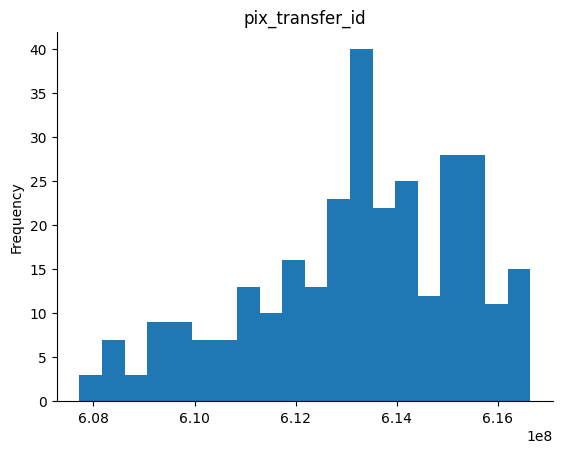

In [30]:
# @title pix_transfer_id

from matplotlib import pyplot as plt
df_get_blocked_users['pix_transfer_id'].plot(kind='hist', bins=20, title='pix_transfer_id')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [31]:
print("Amount total R$: {:.2f}\nNúmero de infrações a serem abertas: {}".format(df_get_blocked_users['amount'].sum(), df_get_blocked_users['pix_transfer_id'].nunique()))

Amount total R$: 207449.75
Número de infrações a serem abertas: 301


In [32]:
infractions = df_get_blocked_users['payload'].apply(json.loads).tolist()

In [33]:
infractions

[{'pix_transfer_id': '610933727',
  'user_id': '27555376',
  'amount': '680',
  'offense_group': 'pix',
  'name': 'infraction',
  'fraudster_account': 'DEBITED_PARTICIPANT',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': '609732832',
  'user_id': '31329281',
  'amount': '255',
  'offense_group': 'pix',
  'name': 'infraction',
  'fraudster_account': 'DEBITED_PARTICIPANT',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': '614407004',
  'user_id': '32389455',
  'amount': '250',
  'offense_group': 'pix',
  'name': 'intermediary',
  'fraudster_account': 'DEBITED_PARTICIPANT',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': '614570007',
  'user_id': '18134797',
  'amount': '150',
  'offense_group': 'pix',
  'name': 'intermediary',
  'fraudster_account': 'DEBITED_PARTICIPANT',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': '615967795',
  'user_id': '6580952',
  'amount': '124',
  'offense_group': 'pix',
  'name': 'intermediary',
  'fraudste

In [34]:
#@title -- Mock Dictionary for testing before opening

formatted_infractions = []

for infraction in infractions:

    analysis_description = "Usuário é suspeito de fraude utilizando pix."

    if infraction['name'] in ['infraction', 'intermediary']:
          analysis_description = "Conta remetente bloqueada por atuar com triangulação em pix."
    elif infraction['name'] == 'fake_ad':
          analysis_description = "Conta remetente bloqueada por golpe de falsa propaganda, personificando empresa de renome."

    formatted_infraction = {
        "pix_transfer_id": int(infraction['pix_transfer_id']),
        "analysis": analysis_description,
        "reason_name": "SCAM",
        "infraction_type": f"{infraction['infraction_type']}",
    }

    formatted_infractions.append(formatted_infraction)

In [35]:
formatted_infractions

[{'pix_transfer_id': 610933727,
  'analysis': 'Conta remetente bloqueada por atuar com triangulação em pix.',
  'reason_name': 'SCAM',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': 609732832,
  'analysis': 'Conta remetente bloqueada por atuar com triangulação em pix.',
  'reason_name': 'SCAM',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': 614407004,
  'analysis': 'Conta remetente bloqueada por atuar com triangulação em pix.',
  'reason_name': 'SCAM',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': 614570007,
  'analysis': 'Conta remetente bloqueada por atuar com triangulação em pix.',
  'reason_name': 'SCAM',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': 615967795,
  'analysis': 'Conta remetente bloqueada por atuar com triangulação em pix.',
  'reason_name': 'SCAM',
  'infraction_type': 'REFUND_REQUEST'},
 {'pix_transfer_id': 614132717,
  'analysis': 'Conta remetente bloqueada por atuar com triangulação em pix.',
  'reason_name'

In [36]:
raise RuntimeError('stop here')

RuntimeError: stop here

In [ ]:
import json
import requests
import time

print("Starting...")


headers = {
    'Content-Type': 'application/json',
    'Authorization': key_master
}

base_url = "https://infinitepay-risk-api.services.production.cloudwalk.network/pix_infractions/"

for infraction in infractions:
    print(f"Processing infraction with pix_transfer_id: {infraction['pix_transfer_id']}")
    print(f"Infractions: {infractions}")

    analysis_description = "Usuário é suspeito de fraude utilizando pix."

    if infraction['name'] in ['infraction', 'intermediary']:
        analysis_description = "Conta remetente bloqueada por atuar com triangulação em pix."
    elif infraction['name'] == 'fake_ad':
        analysis_description = "Conta remetente bloqueada por golpe de falsa propaganda, personificando empresa de renome."
    elif infraction['name'] == 'consumer_dispute':
        analysis_description = "Conta do remetente bloqueada devido a suspeitas de fraude de chargeback"

    data = {
        "pix_transfer_id": int(infraction['pix_transfer_id']),
        "analysis": analysis_description,
        "reason_name": "SCAM",
        "infraction_type": f"{infraction['infraction_type']}",
    }

    try:
        response = requests.post(base_url, headers=headers, json=data)

        if response.status_code == 200:
            print(f"Infraction uploaded successfully for pix_transfer_id: {infraction['pix_transfer_id']}")
            print(response.json())
        else:
            print(f"Failed to upload infraction for pix_transfer_id: {infraction['pix_transfer_id']}")
            print(f"Status code: {response.status_code}, Error: {response.text}")

    except Exception as e:
        print(f"An error occurred: {e}")

#    time.sleep(2)